In [535]:
from lightkurve import KeplerLightCurveFile, KeplerTargetPixelFile
from george import kernels
from george.metrics import Metric
import matplotlib.pyplot as pl
import numpy as np
import george
from astropy.stats import median_absolute_deviation

In [536]:
strLC = KeplerLightCurveFile.from_archive(206208968)
strPF = KeplerTargetPixelFile.from_archive(206208968)

Found 1 File(s)
INFO: Found cached file ./mastDownload/K2/ktwo206208968-c03_lc/ktwo206208968-c03_llc.fits with expected size 368640. [astroquery.query]
Found 1 File(s)
INFO: Found cached file ./mastDownload/K2/ktwo206208968-c03_lc/ktwo206208968-c03_lpd-targ.fits.gz with expected size 6948542. [astroquery.query]


/anaconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/anaconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


Loading BokehJS ...

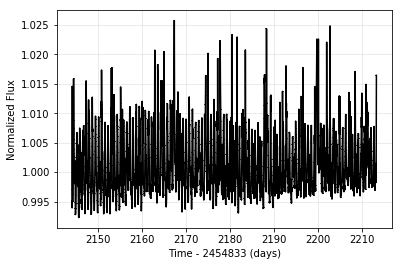

Output()

In [537]:
strPDC = strLC.PDCSAP_FLUX.remove_outliers()
strPDC.plot()
strPF.interact(lc = strPDC)

0.0041883886
2.7412834e-05


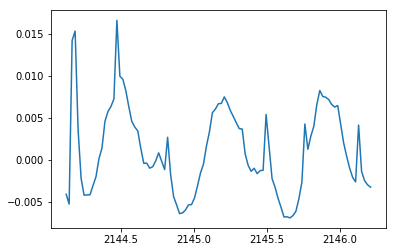

In [538]:
y = strPDC.flux[:100]
x = strPDC.time[:100]
y = (y/np.median(y)) - 1 # sets the function to begin at 0
x = x[np.isfinite(y)]
y = y[np.isfinite(y)] # removes NaN values

#pl.errorbar(x, y,fmt=".k", capsize=0)

pl.plot(x,y)
print(median_absolute_deviation(y))
print(np.var(y))


In [539]:
kernel = np.var(y) * kernels.ExpSine2Kernel(gamma = 1, log_period = 1) * kernels.ExpSquaredKernel(1.0e-2) 
gp = george.GP(kernel)
gp.compute (x, y)
x_pred = x

predVar = gp.predict(y,x_pred,return_var=True)

print ("initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
#initial ln-likelihood: 137.95

from scipy.optimize import minimize 

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)


result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
#print("\n Final ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

initial ln-likelihood: 436.57
      fun: -438.6822485683519
 hess_inv: array([[ 2.26232986e-01,  2.92999274e+01, -1.24101916e+02,
         7.15315118e-02],
       [ 2.92999274e+01,  4.94229800e+06, -2.09367091e+07,
         5.06898407e+02],
       [-1.24101916e+02, -2.09367091e+07,  8.86927259e+07,
        -2.14716248e+03],
       [ 7.15315118e-02,  5.06898407e+02, -2.14716248e+03,
         2.18512521e-01]])
      jac: array([ 1.74209770e-06,  1.07379381e-09, -5.74956575e-10, -3.82408872e-06])
  message: 'Optimization terminated successfully.'
     nfev: 37
      nit: 36
     njev: 37
   status: 0
  success: True
        x: array([-11.43591848,   0.14057236,   4.50075849,  -4.50782359])


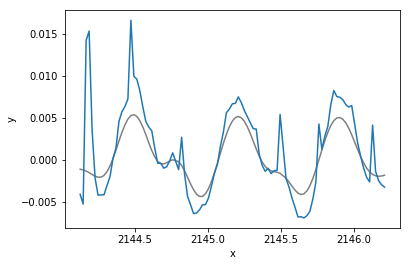

In [540]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

#pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
#                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
#pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#pl.xlim()
pl.plot(x, y)
pl.xlabel("x")
pl.ylabel("y");

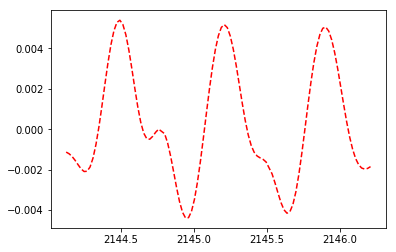

In [541]:
pl.plot(x_pred,pred, "--r")